In [1]:
#!pip install -U jupyter
#!pip install torch
#!pip install torchsummary
#!pip install torchvision
#!pip install tensorflow-gpu
#!pip install pycocotools
#!conda remove tensorflow-gpu
#!conda install pytorch torchvision cudatoolkit=10.2 -c pytorch
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.5/index.html
#!pip install opencv-python 

In [1]:
import torch, torchvision
print(torch.__version__,torch.cuda.is_available())
device = torch.device("cuda") 


1.5.0+cu101 True


In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import cv2
import pickle
import random
from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm
import deepdish as dd
import pycocotools as pycoco
import warnings
import os
warnings.filterwarnings("ignore")

#### Some detectron2 utilities

In [3]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from skimage import measure
torch.cuda.empty_cache()

## Train on  a custom dataset (fine tuning)

first need to register a dataset in the coco formart  to work with predefined data loaders


In [37]:
os.getcwd()

'/mnt/lts/nfs_fs02/sadow_lab/personal/moselim/adhoc/DetectronCheck/scr'

In [4]:
def get_annos():
    with open('check_box_annotations_48.pickle', 'rb') as f:
        annotations = pickle.load(f)
        
    from sklearn.model_selection import train_test_split as tts
    train_annotations,test_annotations = tts(annotations,test_size = 0.2, random_state = 75, shuffle = True)
    data = {'train':train_annotations,'val':test_annotations}
    return data

def category_id(classname):
    if classname =='no':
        return 0
    elif classname =='yes':
        return 1


def create_dataset(annotation):
    dataset_dicts = []
    image_path = os.getcwd().replace("scr",'images') + '/'
    for im in range(len(annotation)):
        dict1 = {}
        
        dict1["file_name"] = image_path+annotation[im]["file_name"]
        height, width = cv2.imread(dict1["file_name"]).shape[:2]
        dict1["height"] = height
        dict1["width"] = width
        dict1["image_id"] = (im+1)
        
        objs = []
        for anno in annotation[im]['annotations']:
            #assert not anno["region_attributes"]
            try:
                cat =  category_id(list(anno['region_attributes']['filled'].keys())[0])
                anno = anno["shape_attributes"]
                px = anno["all_points_x"]
                py = anno["all_points_y"]
                poly = [(x+0.5, y+0.5) for x,y in zip(px,py)]
                poly = [p for x in poly for p in x]

                obj = {
                    "bbox":[np.min(px), np.min(py), np.max(px), np.max(py)],
                    "bbox_mode":BoxMode.XYXY_ABS,
                    "segmentation": [poly],
                    "category_id":cat,
                    "iscrowd":0,
                    }
                objs.append(obj)
            except Exception as e:
                print("image  "+  dict1["file_name"] + ": ", e)
            
        dict1["annotations"] = objs
        
        dataset_dicts.append(dict1)
    return dataset_dicts


def register_dset():
    DatasetCatalog.clear()
    for d_set in data:
        DatasetCatalog.register("checknet_%s"%d_set, lambda d_set=d_set: create_dataset(data[d_set]))
        MetadataCatalog.get("checknet_%s"%d_set).set(thing_classes = ["no",'yes'])

### load annotations, Register dataset


In [5]:
data = get_annos()
register_dset()

----

### Now create a detectron config and defaultPredictor to run inference

In [6]:
cfg =get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 #model threshold
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml")
predictor = DefaultPredictor(cfg)

### check dataset registration success, load visualize annotations ontop of image

In [ ]:
### Train test annotation split 
fish_metadata = MetadataCatalog.get("checknet_train")
dataset_dicts = create_dataset(data["train"])

plt.figure()

r = c = 1
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(r,c,figsize=(17,12))
plt.xticks([])
plt.xticks([])
i=0
j=0
for d in random.sample(dataset_dicts,r*c):
    if i == r:
        i = 0
        j+=1
    img = cv2.imread(d['file_name'])
    visualizer = Visualizer(img[:,:,::-1], metadata = fish_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    axarr.imshow(Image.fromarray(vis.get_image()[:,:,::-1]))
    i+=1
    
plt.show()

-----

## Train

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("checknet_train",)
cfg.DATASETS.TEST = () 
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml")  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.GAMMA = 0.02
cfg.SOLVER.MAX_ITER = 3000    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

### Tensorboard

In [ ]:
%matplotlib inline 
%reload_ext tensorboard
%tensorboard --logdir output

## Inference 

In [ ]:
from detectron2.utils.visualizer import ColorMode

# load weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.70   # set the testing threshold for this model
# Set training data-set path
cfg.DATASETS.TEST = ("checknet_val", )
# Create predictor (model for inference)
predictor = DefaultPredictor(cfg)

plt.figure()

r = 1
c = 1
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(r,c,figsize=(20,12))
plt.xticks([])
plt.xticks([])
i=0
j=0

dataset_dicts = create_dataset(data["val"])
for d in random.sample(dataset_dicts, r*c):
    if i == r:
        i = 0
        j+=1
        
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=fish_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axarr.imshow(Image.fromarray(v.get_image()[:, :, ::-1]))
    i+=1
plt.show()

In [18]:
print(outputs["instances"].to("cpu").pred_classes)
imsa = Image.fromarray(v.get_image()[:, :, ::-1])
imsa.save('test.jpg')

tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1])


## Intersection over  union Evaluation

In [34]:
from iou import intersection_over_Union
from tqdm import tqdm


iou = intersection_over_Union()
image_path = os.getcwd().replace("scr",'images') + '/'

def get_box(randnum, cat):
    count = len(annotations[randnum]["annotations"])
    found = 0
    for k in range(count):
        #category = annotations[randnum]["annotations"][k]["region_attributes"]["region"]
        category=list(annotations[randnum]["annotations"][k]['region_attributes']['filled'].keys())[0]
        if category.strip()==cat.strip():
            found = k
            break
    
    anno = annotations[randnum]["annotations"][found]["shape_attributes"]
    px = anno["all_points_x"]
    py = anno["all_points_y"]
    poly = [(x+0.5, y+0.5) for x,y in zip(px,py)]
    poly = [p for x in poly for p in x]
    real = [np.min(px), np.max(px),np.min(py), np.max(py)]
    return real

In [35]:
cats = ["yes","no"]
errors_all = {k:[] for k in cats}
ious_all = {k:[] for k in cats}
ious_all["object_count"] = []
ious_all["predicted_count"] = []
annotations = data['val']

for kat in cats:
    ious = []
    errors = []
        
    for k in tqdm(range(len(annotations))):
        randnum = k
        #number = int(annotations[randnum]['file_name'].replace(".JPG", ""))
        num_name = annotations[randnum]["file_name"]
        num_stuff = max(0,len(annotations[randnum]["annotations"]))
        if kat == "yes":
            ious_all["object_count"].append(num_stuff)
            ious_all["predicted_count"].append(len(outputs["instances"].to("cpu").pred_classes))

        name = image_path+annotations[randnum]["file_name"]
        img = cv2.imread(name)
        top = 0
        thresh = 0.3
        rotations = 0
        rotate =True
        
        while rotate:
            outputs = predictor(img)
            real = get_box(randnum, kat)

            classes = [k.item() for k in outputs["instances"].to("cpu").pred_classes]
            temp = 0
            for j in range(len(classes)):
                #print("fish in position: ",classes.index(0))
                pred = [y.item() for y in [k for k in outputs["instances"].to("cpu").pred_boxes[j]][0]]
                hold = pred[1]
                pred[1] = pred[2]
                pred[2] = hold
                temp = min(max(max(iou.IoU(real,pred),0),temp), 1)
            rotate  = (temp < thresh and rotations<3)
            top = max(top,temp)
            if rotate:
                img = cv2.rotate(img,cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
                rotations+=1
                
        if top<thresh:
            errors.append([randnum,num_name])
        ious.append(top)
        
    errors_all[kat] = errors
    ious_all[kat] = ious
    print("mean iou: ",np.mean(ious))
    print("num errors: ", len(errors))


100%|██████████| 10/10 [01:21<00:00,  8.19s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

mean iou:  0.837105635526014
num errors:  0



100%|██████████| 10/10 [01:20<00:00,  8.02s/it]

mean iou:  0.7973119141584286
num errors:  0


In [50]:
kk = pd.DataFrame(ious_all)
kk['accuracy'] = kk['predicted_count']/50
print(np.mean(kk['accuracy']))

0.9579999999999999


-----

### Deploy

In [24]:
import torch, torchvision
print(torch.__version__,torch.cuda.is_available())
device = torch.device("cuda")
torch.cuda.empty_cache()

import warnings
warnings.filterwarnings("ignore") 

import numpy as np
import random
import pandas as pd
import os
import sys
from matplotlib import pyplot as plt

import cv2
from PIL import Image
from skimage import measure
import sklearn

import pycocotools as pycoco
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
%matplotlib inline
np.set_printoptions(threshold=sys.maxsize)

class trained_model:
    def __init__(self):
        self.cfg = get_cfg()
        self.cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"))
        self.cfg.MODEL.WEIGHTS = os.path.join(self.cfg.OUTPUT_DIR, "model_final_check.pth")
        self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.60
        self.cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
        self.predictor = DefaultPredictor(self.cfg)
        #check_metadata = MetadataCatalog.get("checknet_train").set(thing_classes = ["no", 'yes'])
        #MetadataCatalog.get("fishnet_val").set(thing_classes = ["fish", 'blue', 'yellow'])
        #cfg.DATASETS.TEST = ("fishnet_val",)

    def make_prediction(self,image):
        #im = cv2.imread(d["file_name"])
        outputs = self.predictor(image)
        return image,outputs

    
    def show_prediction(self,im,outputs):
        plt.figure()

        r =c= 1
        #f, axarr = plt.subplots(r,c,figsize=(20,12))
        #plt.xticks([])
        #plt.xticks([])
        v = Visualizer(im[:, :, ::-1],
                        metadata=MetadataCatalog.get("checknet_train"), 
                        scale=0.8, 
                        instance_mode=ColorMode.IMAGE_BW
                      )
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        pred_im = Image.fromarray(v.get_image()[:, :, ::-1])
        #axarr.imshow(pred_im)
        #plt.show()
        return pred_im
    
    def get_json_result(self,outputs):
        scores = [k.item() for k in outputs["instances"].to("cpu").scores]
        classes = [y.item() for y in outputs["instances"].to("cpu").pred_classes]


        vertices = {'v1':[],'v2':[],'v3':[],'v4':[]}
        for box in range(len(scores)):
            box_vertices = [y.item() for y in [k for k in outputs["instances"].to("cpu").pred_boxes[box]][0]]
            i=0
            for v in vertices:
                vertices[v].append(box_vertices[i])
                i+=1

        v_frame = pd.DataFrame(vertices) 
        v_frame['scores'] =scores
        v_frame['classes'] =classes
        v_frame = v_frame.sort_values(by = ['v2','v4','v1','v3'],ascending=True).reset_index(drop=True)
        v_frame2 =v_frame[['classes','scores']].to_dict(orient='dict')
        return v_frame2

1.5.0+cu101 True


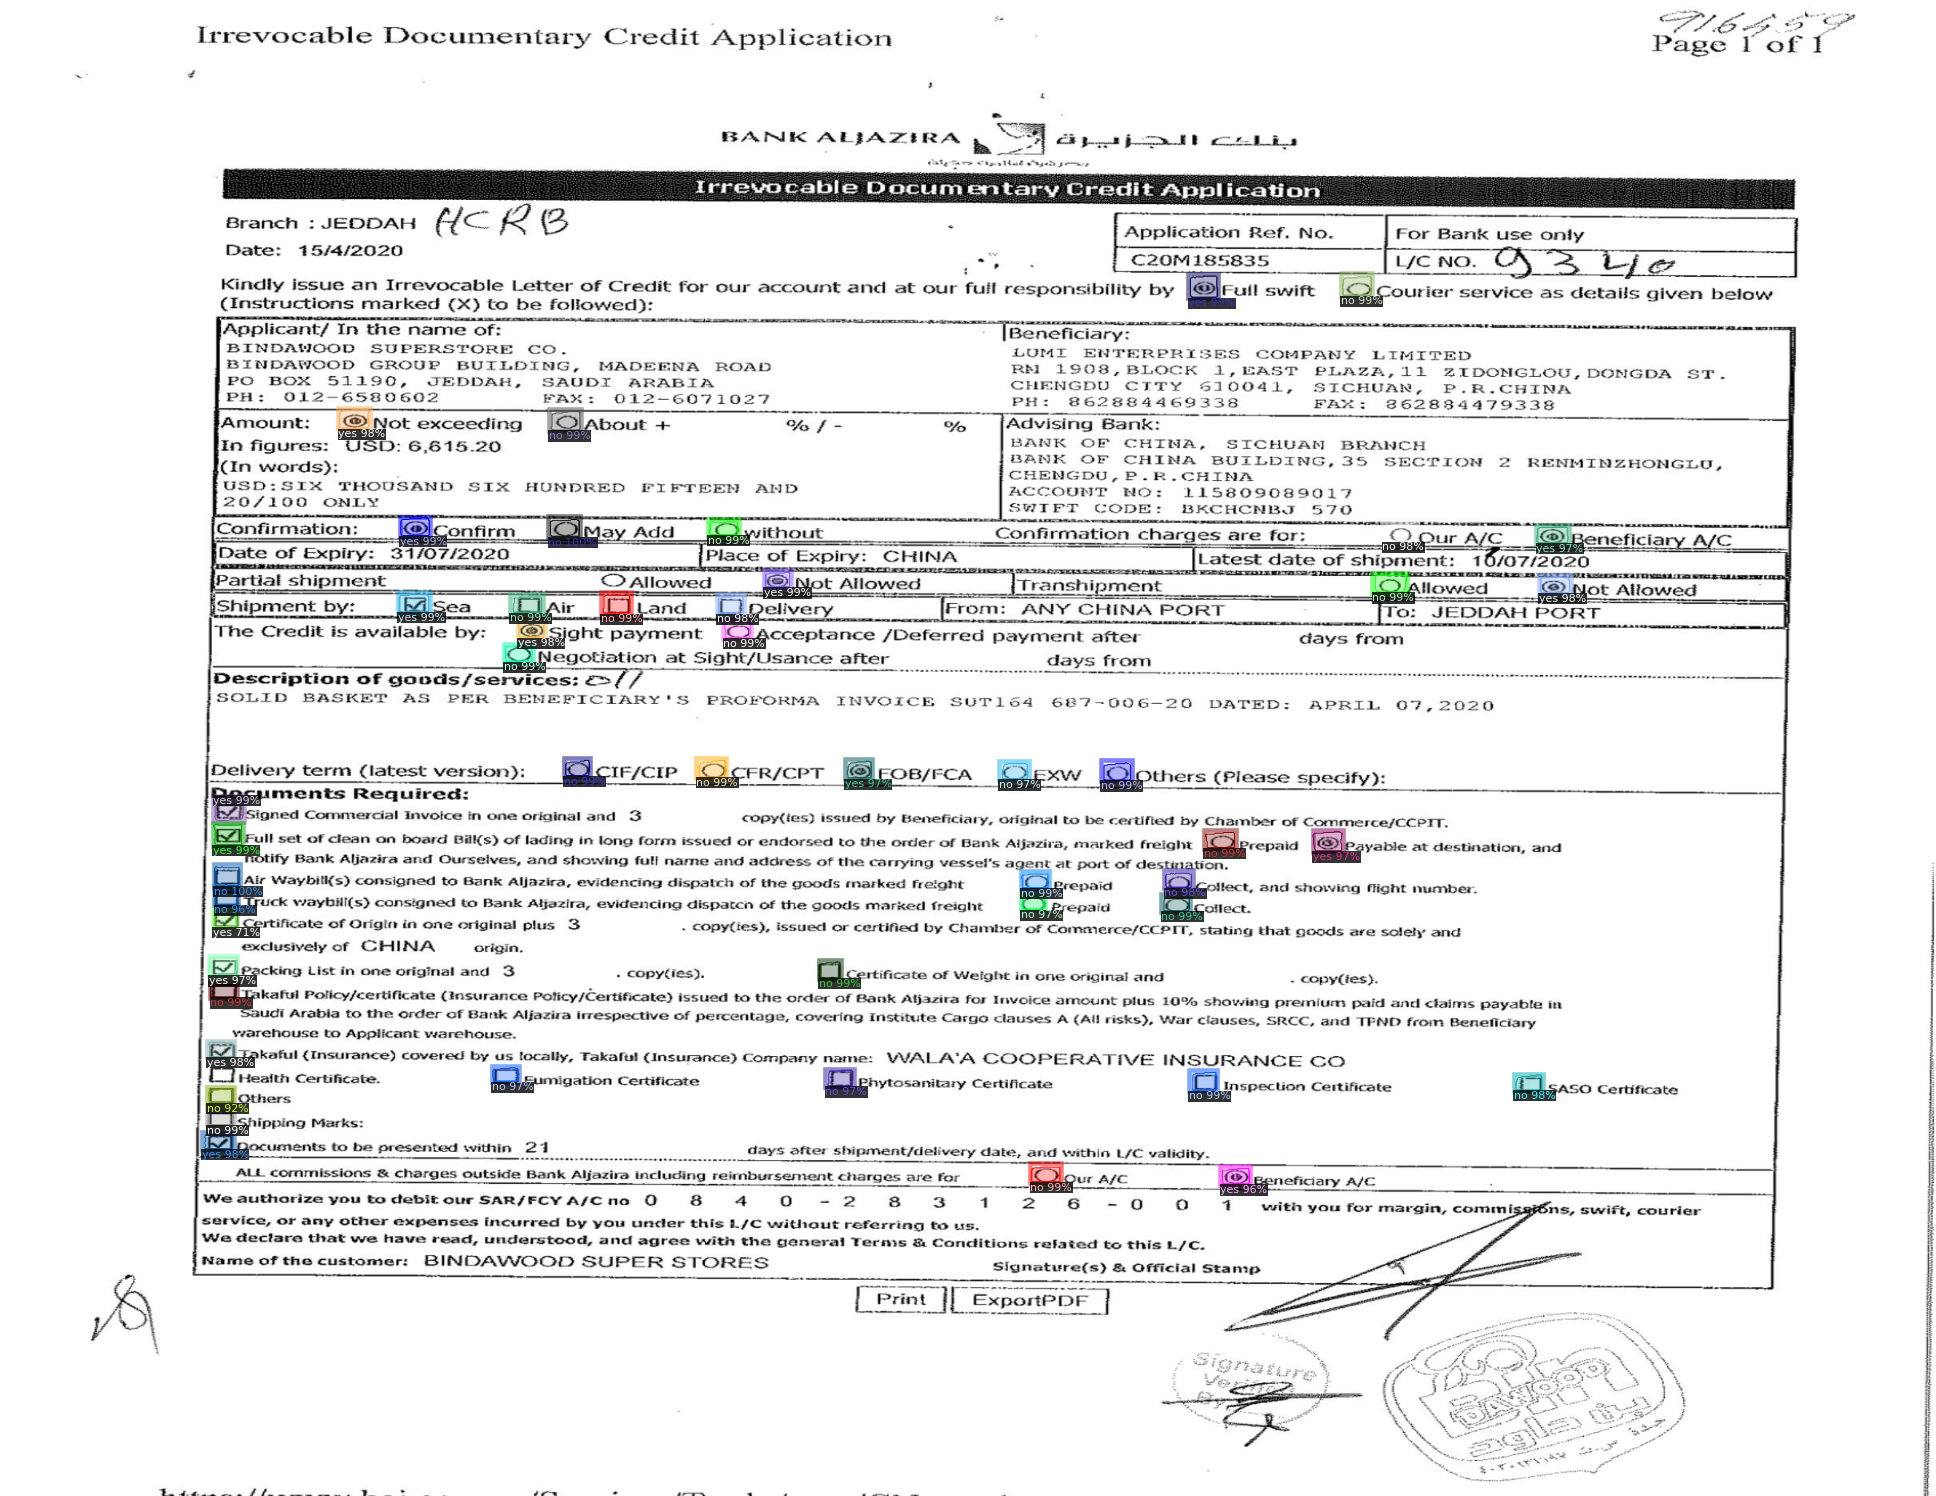

<Figure size 432x288 with 0 Axes>

In [27]:
image_path = os.getcwd().replace("scr",'images') + '/'
img = cv2.imread(image_path+'LC 1_3.jpg')
model = trained_model()
im,outputs = model.make_prediction(img)
model.show_prediction(im,outputs)
#model.get_json_result(outputs)

In [ ]:
# COnvert